# ASAS-SN-J06000 Light Curve Analysis

M Kenworthy kenworthy@strw.leidenuniv.nl // Leiden Observatory

2019 Dec 26

Astronomers telegram http://www.astronomerstelegram.org/?read=13346 reports an unusual dimming star ASASSN-V J060000.76-310027.83.

No dimming for 2200 days, then it is dipping with increasing drop over 0.25 mags over 1 day.

Eric Mamajek tweet on it: https://twitter.com/EricMamajek/status/1205229364037570561

This looks like a completely normal, negligibly reddened ~K5.5 dwarf. Low velocity and spot on solar main sequence => thin disk. 3D velocity no where near nearby very young clusters/associations, so unlikely to be <100 Myr. #GaiaDR2 Teff and luminosity appear to be spot on.


ASASSN-V J060000.76-310027.83 (position from Gaia DR2, source_id=2891196718939580672, d=156 pc, L=0.14 L_sun, T_eff=4270 K)

In [3]:
import numpy as np
from astropy import constants as c
from astropy import units as u
import matplotlib.pyplot as plt

params = {'legend.fontsize': 'x-large',
          'figure.figsize': (15, 5),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

@u.quantity_input
def atoP(a:u.au, m1:u.M_sun, m2:u.M_jup)->u.year:
    """
    Calculate period from orbital radius and masses

    Args:
        a: semi-major axis
        m1, m2: Primary and secondary masses

    Returns:
        P: orbital period

    >>> import astropy.units as u
    >>> atoP(1.*u.au, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 0.99954192 yr>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)

    const = c.G/(4.*np.pi*np.pi)

    mu = m1 + m2

    P2 = np.power(a,3.)/(const*mu)

    P = np.power(P2, 0.5)
    return P

@u.quantity_input
def Ptoa(P:u.year, m1:u.M_sun, m2:u.M_jup)->u.au:
    """calculate orbital radius from period

    Args:
        P: orbital period
        m1, m2: Primary and secondary masses

    Returns:
        a: semi-major axis

    >>> import astropy.units as u
    >>> Ptoa(11.86*u.year, 1.0*u.M_sun, 1.0*u.M_jup)
    <Quantity 5.20222482 AU>
    """

    # a^3/P^2 = (G/4pipi) (m1 + m2)
    const = c.G / (4.*np.pi*np.pi)
    mu = m1 + m2
    a3 = P*P*const*mu
    aa = np.power(a3, 1./3.)
    
    return aa

@u.quantity_input
def rhill(m1: u.Msun, m2: u.Mjup, a: u.au)->u.au:
    """
    Hill radius of the secondary m2 orbiting around m1
    
    Args:
        m1, m2: primary and secondary masses
        a: distance between m1 and m2

    Returns:
        rhill: radius of Hill sphere of m2

    >>> import astropy.units as u
    >>> rhill(1.0 * u.M_sun, 1.0 * u.M_jup, 5.2 * u.au)
    <Quantity 0.35489325 AU>
    """

    mu = m2 / (m1 + m2)
    rh = a * np.power(mu/3., 1./3.)
    return rh

## Read in all g data



In [95]:
# aavso
from astropy.io import ascii
import matplotlib
aavso_file = 'data/aavso/aavsodata_5dfcc34ef2852.txt'
aavso_file = 'data/aavso/aavsodata_5e054bb1577ce.txt'
ta = ascii.read(aavso_file)

from astropy.time import Time

# read in JD into a Time object for easy conversion

ta['MJD'] = ta['JD'] - 2400000.5

times = Time(ta['JD'], format='jd')

from datetime import datetime

now = Time(datetime.utcnow(),format='datetime')

print('current MJD is {}'.format(now.mjd))

# get a list of the unique bandpasses
ta_by_band = ta.group_by('Band')

current MJD is 58844.00794134994


In [96]:
ta.show_in_notebook()

idx,JD,Magnitude,Uncertainty,HQuncertainty,Band,Observer Code,Comment Code(s),Comp Star 1,Comp Star 2,Charts,Comments,Transfomed,Airmass,Validation Flag,Cmag,Kmag,HJD,Star Name,Observer Affiliation,Measurement Method,Grouping Method,ADS Reference,Digitizer,Credit,MJD
0,2458829.82906,14.178,0.028,--,V,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 13.159 K = 12.814,0,1.252,Z,18.518,18.155,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58829.3290599999
1,2458829.8298,14.133,0.029,--,V,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 13.159 K = 12.814,0,1.256,Z,18.555,18.153,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58829.32979999995
2,2458829.83048,12.598,0.026,--,I,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 12.510 K = 12.121,0,1.259,Z,19.565,19.221,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58829.330480000004
3,2458829.83105,12.581,0.027,--,I,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 12.510 K = 12.121,0,1.262,Z,19.588,19.199,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58829.33105000015
4,2458830.82618,14.275,0.028,--,V,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 13.159 K = 12.814,0,1.251,Z,18.574,18.216,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58830.32617999986
5,2458830.82691,14.206,0.027,--,V,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 13.159 K = 12.814,0,1.255,Z,18.574,18.205,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58830.32690999983
6,2458830.82759,12.603,0.028,--,I,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 12.510 K = 12.121,0,1.258,Z,19.647,19.235,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58830.327589999884
7,2458830.82815,12.622,0.028,--,I,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 12.510 K = 12.121,0,1.261,Z,19.643,19.261,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58830.32814999996
8,2458831.62534,14.063,0.013,--,V,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 13.159 K = 12.814,0,1.137,Z,18.595,18.22,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58831.125339999795
9,2458831.6303,14.078,0.014,--,V,HMB,--,UCAC4 296-008893,UCAC4 296-009008,--,STANDARD MAG: C = 13.159 K = 12.814,0,1.121,Z,18.609,18.236,--,ASASSN-V J060000.76-310027.83,VVS,STD,--,--,--,--,58831.130299999844


In [97]:
tasas = ascii.read('data/asassn/asas.ecsv')

tasas['mag'] = tasas['mag'].astype(float)
mask = (tasas['Filter'] == 'g') & (tasas['mag'] < 20) 
tasasv = tasas[mask]

tlco = ascii.read('data/lco/lco.ecsv')


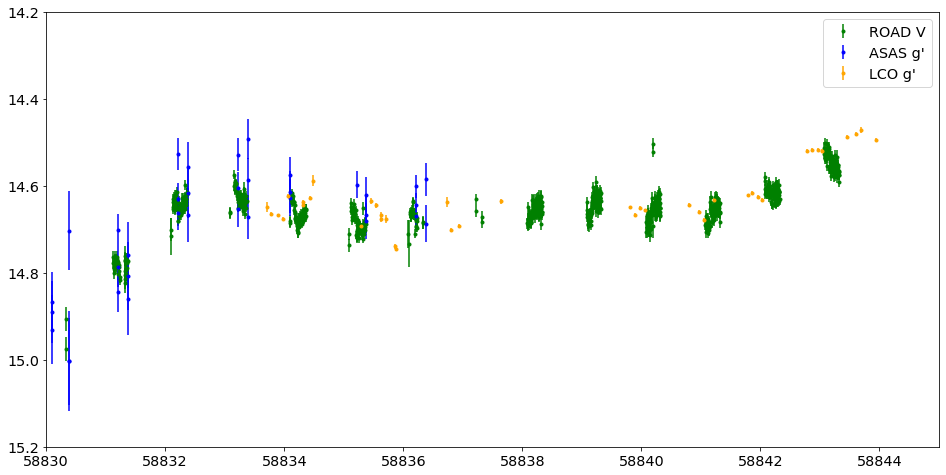

In [103]:
f = plt.figure(figsize=(16,8))
ax = f.add_subplot(111)

# HMB flux
tap = ta[ta['Band']=='V']
plt.errorbar(tap['MJD'],tap['Magnitude']+0.7, yerr=tap['Uncertainty'], fmt='.', color='green', label="ROAD V")
plt.xlim(58830, 58845)
plt.ylim(15.20,14.20)
#tasasv = tasas[(tasas['Filter']=='V')]
#tasasv = tasasv[(tasasv['mag'])<25]
#plt.plot(tasasv['MJD'],tasasv['MJD'])
plt.errorbar(tasasv['MJD'],tasasv['mag'], yerr=tasasv['mag_err'], fmt='.',color='blue', label="ASAS g'")
#plt.plot(tasasv['MJD'],tasasv['mag'])

plt.errorbar(tlco['MJD'],tlco['gmag']+13.1, yerr=tlco['gmag_err'], fmt='.',color='orange', label="LCO g'")

plt.legend()


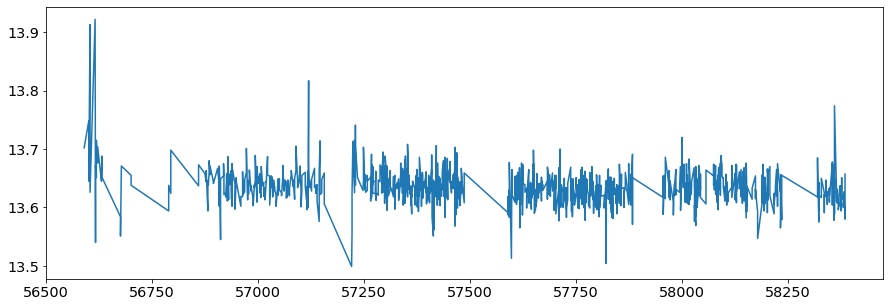

In [48]:

#tasasv = tasas[(tasas['Filter']=='V')]
#tasasv = tasasv[(tasasv['mag'])<25]
#print(np.array(tasas['mag']))
tasas['mag'] = tasas['mag'].astype(float)
mask = (tasas['Filter'] == 'V') & (tasas['mag'] < 20) 
tasasv = tasas[mask]
plt.plot(tasasv['MJD'],tasasv['mag'])
#plt.errorbar(tasasv['MJD'],tasasv['mag'], yerr=tasasv['mag_err'], fmt='.',color='green')




In [70]:
tlco.show_in_notebook()

idx,MJD,gmag,gmag_err,obs
0,58833.703,1.5483392,0.011168719,H
1,58833.785,1.5650146,0.004926161,H
2,58833.895,1.5674055,0.0032656505,H
3,58833.98,1.5756489,0.0034239804,H
4,58834.062,1.5230076,0.0034809678,H
5,58834.312,1.5363892,0.0037496837,H
6,58834.316,1.5439526,0.0038415645,H
7,58834.434,1.5277326,0.004383284,H
8,58834.48,1.4877633,0.011707869,H
9,58834.867,0.7210222,0.023758342,H
